# Load stack_tup

In [1]:
%matplotlib inline
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../Bootstrap/py"))
import qpq9_boot as qpq9b
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                               vsig_cut=400*u.km/u.s,plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']: #CIV overlaps with BAL of background quasar
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0008-0039 and wvobs=4046.04 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0008-0039 and wvobs=4549.59 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 9.3e-05 Gb
Loaded spectra
Using spec-6197-56191-0089.fits.gz for BOSSJ0042+1350
S/N in rest frame: 7.94386588253 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ005718.90-000134.7.fits for BOSSJ0057-0001
S/N in rest frame: 5.99344013527 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Crea

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:247: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [3]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  88.  88.  88.  88.  88.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  88.  88.  88.  88.
  88.]


(1.9295158964119221, 189.13986652183442)

## Stack and Plot

### Mean

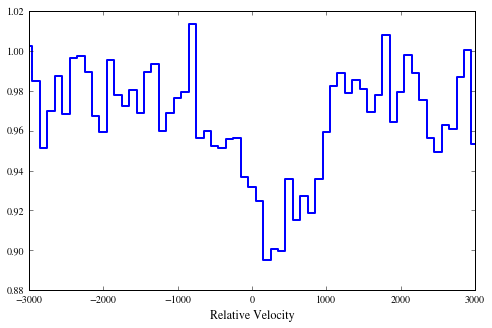

In [4]:
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Median

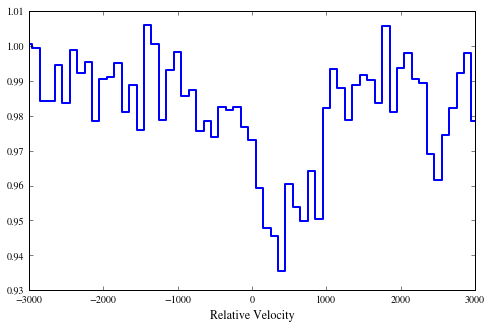

In [5]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write 

In [6]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zIRMgII_1548_mean.fits'
relativistic_equiv = u.doppler_relativistic(1548.195*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zIRMgII_1548_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zIRMgII_1548_mean.fits
Wrote spectrum to Output/QPQ9_zIRMgII_1548_med.fits


## Bootstrap

In [7]:
#Mean
reload(qpq9b)
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/IRMgII_1548_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.58709, Median=0.572014, std=0.494884 for Ntrials=10000
Centroid: Mean = 86.1648, scatter=112.714
Dispersion and scatter of it:  306.976792699 100.429694971
max and min centroid:  476.039002966 -894.568017556
Wrote ../Bootstrap/Output/IRMgII_1548_mean.fits


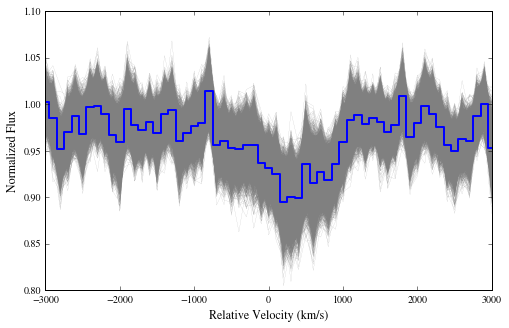

In [8]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1548_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.2107

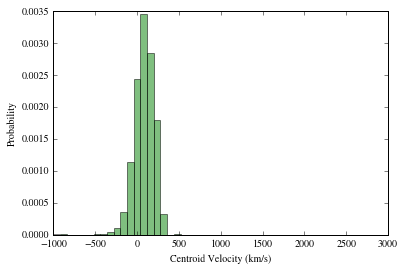

In [9]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5, range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [10]:
#Median
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/IRMgII_1548_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.701454, Median=0.695674, std=0.240534 for Ntrials=10000
Centroid: Mean = 156.749, scatter=124.388
Dispersion and scatter of it:  277.370790879 146.550321525
max and min centroid:  907.0332891 -733.083345258
Wrote ../Bootstrap/Output/IRMgII_1548_med.fits


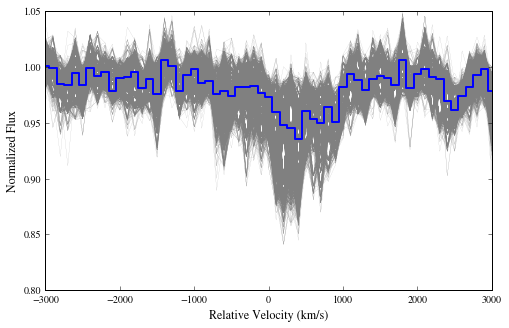

In [11]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1548_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# [OIII] only

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ005718.90-000134.7.fits for BOSSJ0057-0001
S/N in rest frame: 5.99344013527 1 / Angstrom


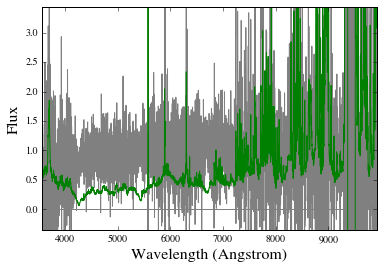

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ023946.44-010644.2_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ023946.44-010644.1_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ023946.45-010644.1.fits for BOSSJ0239-0106
S/N in rest frame: 23.7541053843 1 / Angstrom


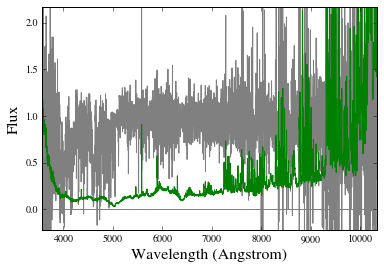

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ080048.74+354231.3.fits
No spectrum found for APOJ0800+3542 and wvobs=4616.78 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ084159.26+392140.0.fits
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ084159.26+392140.0.fits for BOSSJ0841+3921
S/N in rest frame: 14.0936784946 1 / Angstrom


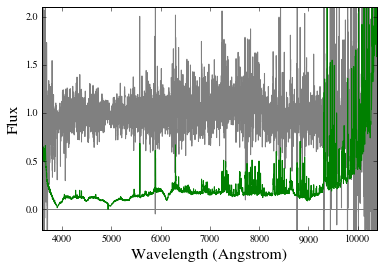

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRSPEC_redux//./SDSSJ085357.49-001106.2.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N in rest frame: 110.799035264 1 / Angstrom


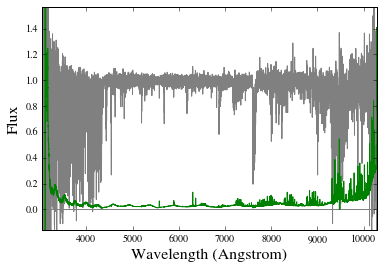

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 2 spectra totalling 0.00072 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ091046.69+041448.4.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ091046.69+041448.4_F.fits.gz for APOJ0910+0414
S/N in rest frame: 55.6813173064 1 / Angstrom


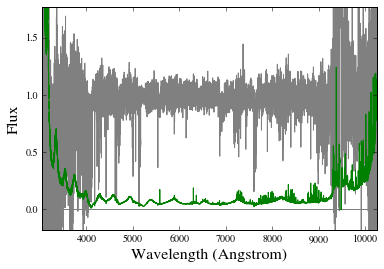

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091430.84+010927.5.fits for BOSSJ0914+0109
S/N in rest frame: 15.4871555291 1 / Angstrom


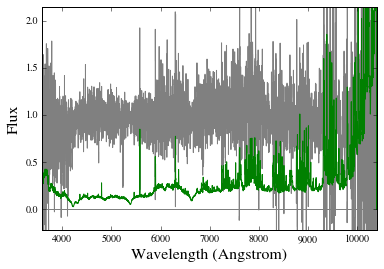

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N in rest frame: 72.1252304234 1 / Angstrom


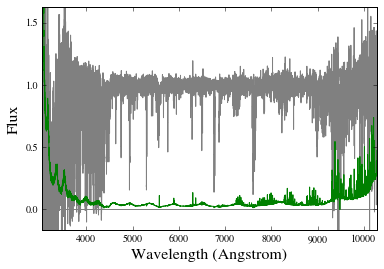

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
No spectrum found for APOJ0938+5317 and wvobs=4747.93 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_6_0/SDSSJ100627.10+480429.9.fits for BOSSJ1006+4804
S/N in rest frame: 16.7551504652 1 / Angstrom


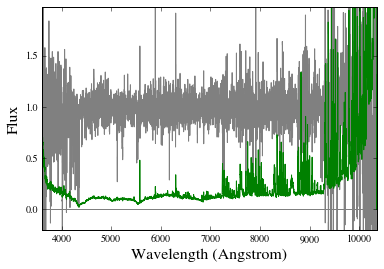

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ103900.01+502652.8_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N in rest frame: 53.3526168379 1 / Angstrom


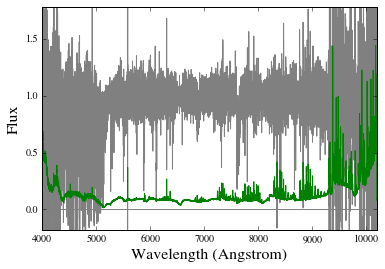

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ114436.65+095904.9_r_F.fits.gz for BOSSJ1144+0959
S/N in rest frame: 235.637256663 1 / Angstrom


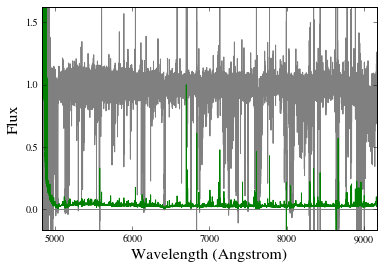

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N in rest frame: 129.809226794 1 / Angstrom


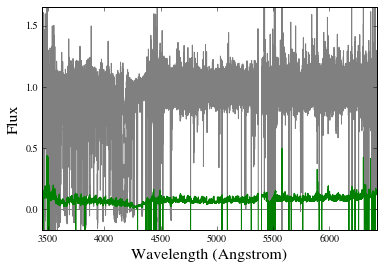

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ121558.82+571555.6.fits
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N in rest frame: 26.908602099 1 / Angstrom


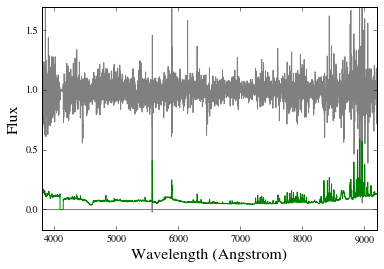

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ123141.73+002913.9_r600_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ123141.73+002913.9_F.fits.gz for BOSSJ1231+0029
S/N in rest frame: 26.4126834013 1 / Angstrom


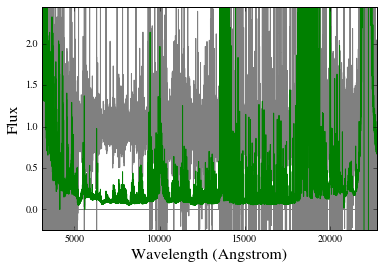

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ140209.52+470117.8.fits
No spectrum found for BOSSJ1402+4701 and wvobs=4514.01 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ142004.12+022708.8_F.fits.gz for BOSSJ1420+0227
S/N in rest frame: 53.8773711206 1 / Angstrom


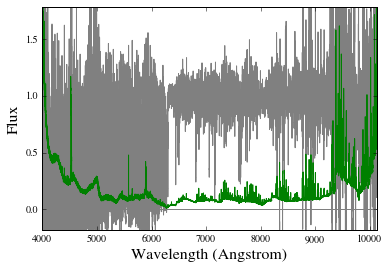

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ142054.92+160342.9.fits
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N in rest frame: 94.0746822297 1 / Angstrom


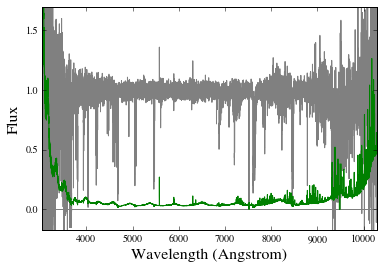

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_r_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/MIKE_redux//./SDSSJ142758.74-012136.2_spl_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142758.74-012136.2_F.fits.gz for BOSSJ1427-0121
S/N in rest frame: 121.599217563 1 / Angstrom


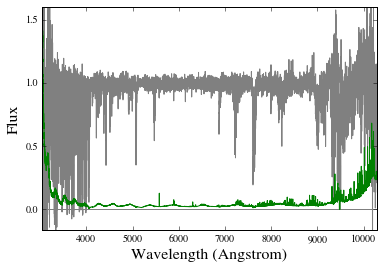

Database is QPQ
Created on 2017-Jan-31
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_7_0/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N in rest frame: 29.7597404899 1 / Angstrom


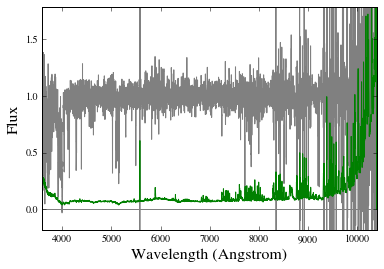

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N in rest frame: 45.7814287976 1 / Angstrom


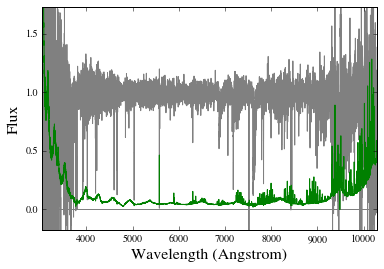

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N in rest frame: 100.411969242 1 / Angstrom


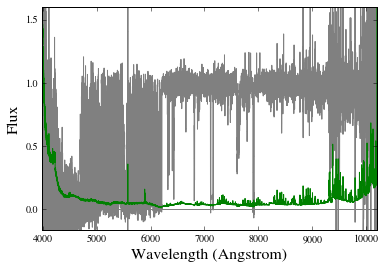

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ214620.98-075303.8_F.fits.gz for APOJ2146-0753
S/N in rest frame: 47.5768031362 1 / Angstrom


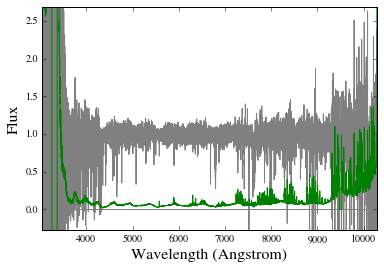

Database is QPQ
Created on 2017-Jan-31
Staged 2 spectra totalling 0.0002 Gb
Loaded spectra
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ220248.31+123656.3.fits
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_7_0/SDSSJ220248.31+123656.3.fits for BOSSJ2202+1236
S/N in rest frame: 13.038603268 1 / Angstrom


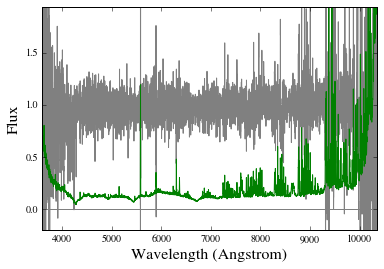

Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 0.0001 Gb
Loaded spectra
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPairs/data/XSHOOTER_redux//./SDSSJ233845.45-000331.8_F.fits.gz for BOSSJ2338-0003
S/N in rest frame: 86.7918762222 1 / Angstrom


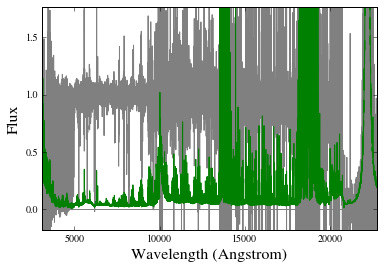

In [12]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=70*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']: #CIV overlaps with BAL of background quasar
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

In [13]:
np.sum(stck_mskN,0)
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']:
        idx_mask.append(ii) 
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

(2.2959557285185497, 120.92202374450571)

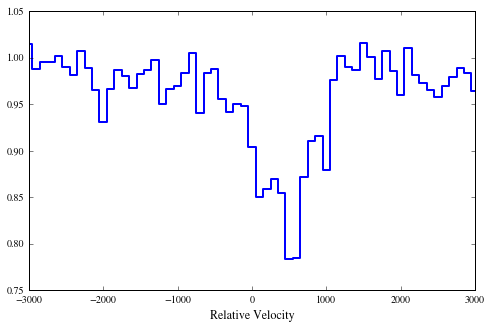

In [14]:
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

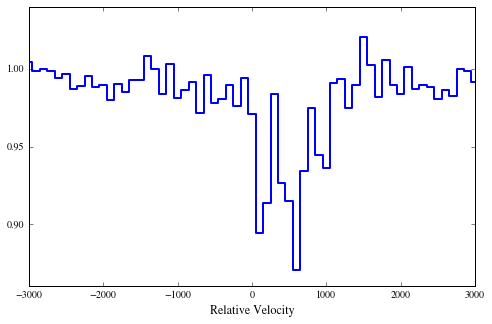

In [15]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [16]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zOIII_1548_mean.fits'
relativistic_equiv = u.doppler_relativistic(1548.195*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zOIII_1548_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zOIII_1548_mean.fits
Wrote spectrum to Output/QPQ9_zOIII_1548_med.fits


## Bootstrap 

In [17]:
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/OIII_1548_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.727789, Median=0.727303, std=0.147104 for Ntrials=10000
Centroid: Mean = 174.853, scatter=79.0915
Dispersion and scatter of it:  238.719519144 52.8307539052
max and min centroid:  575.857636386 -234.252991974
Wrote ../Bootstrap/Output/OIII_1548_mean.fits


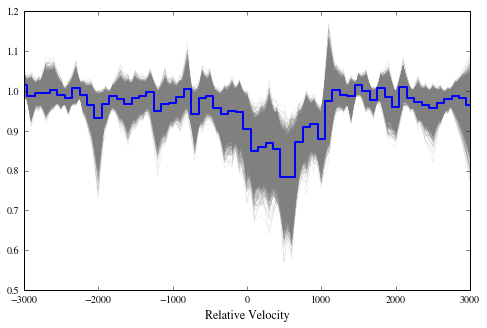

In [18]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1548_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

0.0084

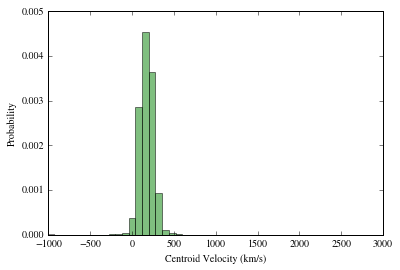

In [19]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen,50,normed=1,facecolor='green',alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [20]:
#Median
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/OIII_1548_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.814437, Median=0.834591, std=0.164281 for Ntrials=10000
Centroid: Mean = 230.707, scatter=125.588
Dispersion and scatter of it:  206.497944196 100.146342002
max and min centroid:  715.093774358 -492.716513389
Wrote ../Bootstrap/Output/OIII_1548_med.fits


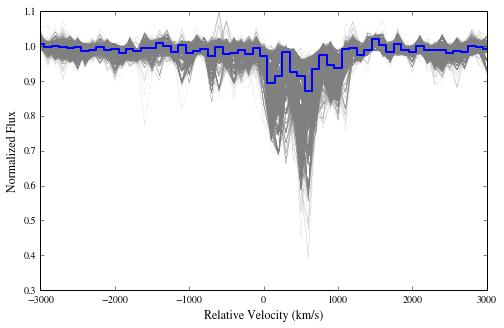

In [21]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1548_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# Plot individual spectra

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0008-0039 and wvobs=4046.04 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
No spectrum found for BOSSJ0008-0039 and wvobs=4549.59 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using spSpec-51879-0419-251.fit.gz for BOSSJ0042+1350
S/N in rest frame: 14.3271179026 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00014 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/TRIPLESPEC_redux//./SDSSJ005717.37-000113.2.fits
No continuum: /u/xavier/Dropbox//QSOPairs/data/ISAAC_redux//

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:222: RuntimeWarning: invalid value encountered in greater
  gdsigval = np.where(self.data['sig'][kk].data > 0.)[0]
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:223: RuntimeWarning: invalid value encountered in less_equal
  badsigval = self.data['sig'][kk].data <= 0.
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:433: RuntimeWarning: invalid value encountered in greater
  gdpx = self.sig > 0.
/Users/lwymarie/python/enigma/enigma/qpq/stacks.py:327: RuntimeWarning: invalid value encountered in less_equal
  bad = np.where(spec.sig.value <= 0.)[0]



Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ214620.68-075250.6_F.fits.gz for APOJ2146-0753
S/N in rest frame: 133.259591506 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 2.4e-05 Gb
Loaded spectra
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ220248.60+123645.5_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/NIRI_redux//./SDSSJ220248.61+123645.5.fits
No spectrum found for BOSSJ2202+1236 and wvobs=4751.74 Angstrom!
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using spSpec-52912-1104-279.fit.gz for BOSSJ2212-0011
S/N in rest frame: 11.643688459 1 / Angstrom
Database is QPQ
Created on 2017-Jan-31
Database is igmspec
Created on 2016-Dec-13
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Using spSpec-52178-0676-077.fit.gz for BOSSJ2255-0001
S/N in rest frame: 10.678832

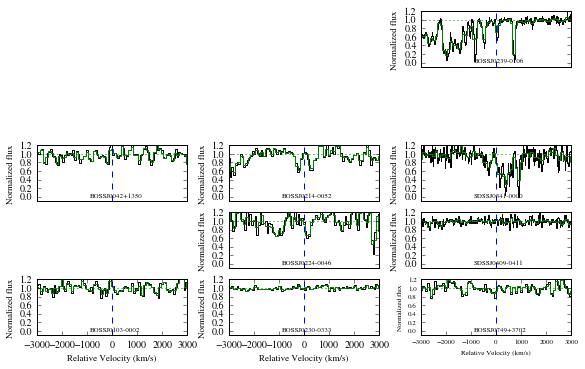

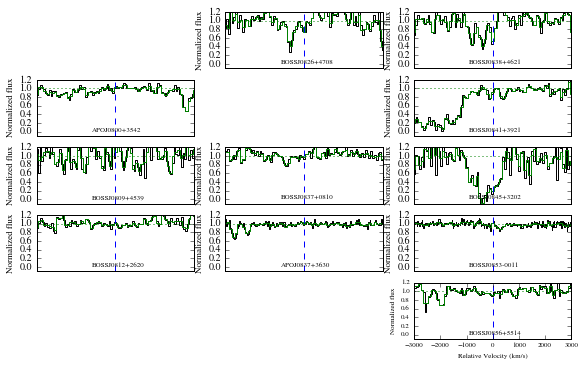

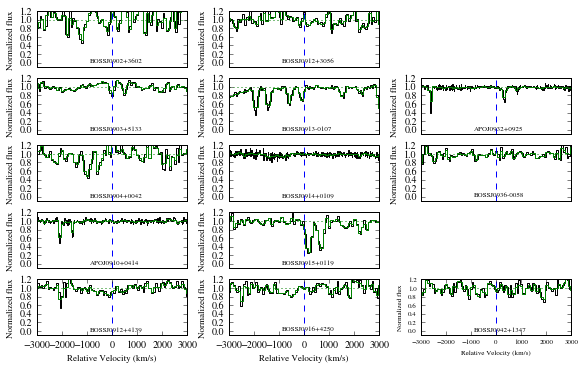

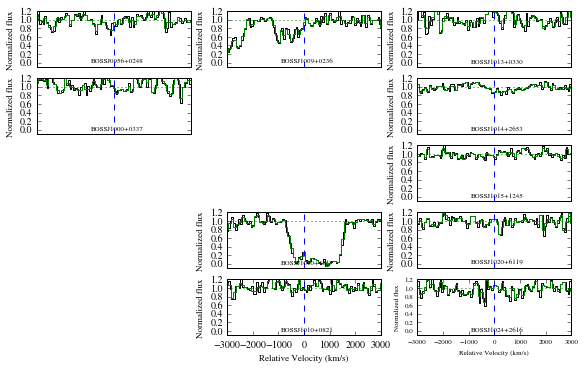

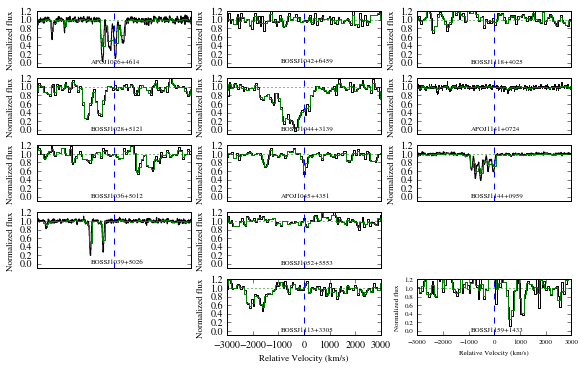

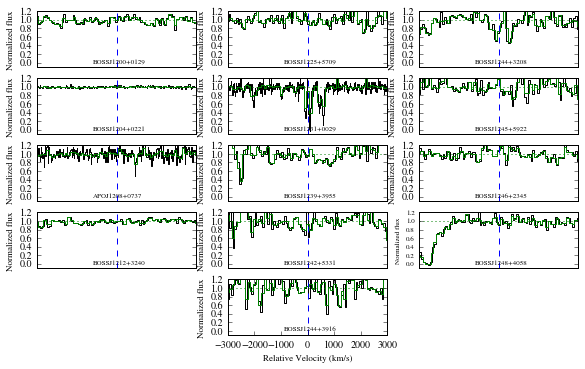

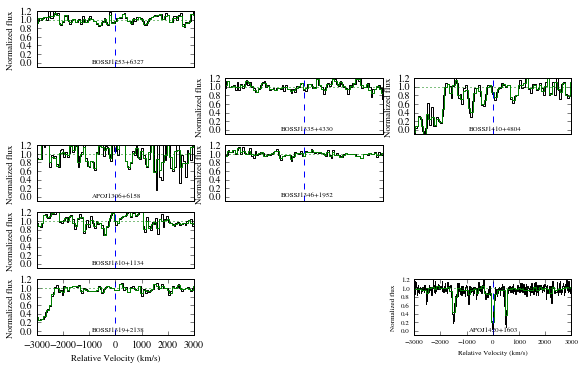

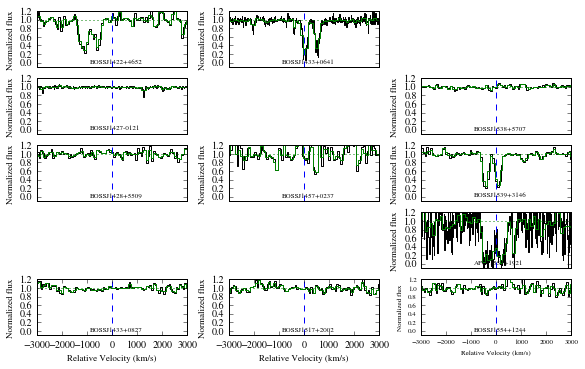

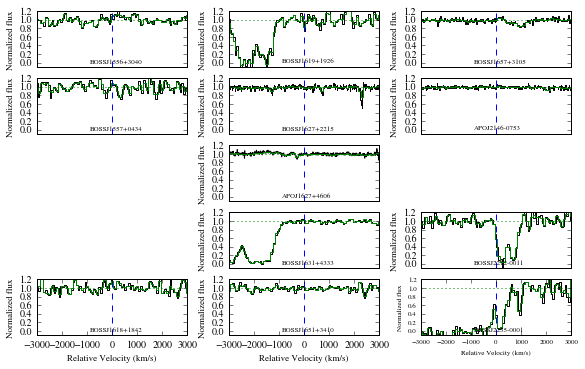

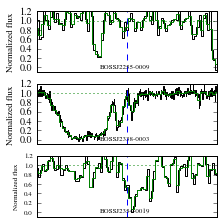

In [3]:
reload(qpq9k)
qpq9k.plt_qpq9(wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,stack_fg=True,zfg_mnx=(1.6,9999))

# Split in two bins of g_UV

## MgII redshift stack

In [ ]:
# Load QPQ9 data structure
enigma_path = imp.find_module('enigma')[1]
QPQ9 = xxf.bintab_to_table(enigma_path+'/data/qpq/qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg)
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']:
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']:
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of R_phys

## MgII redshift stack 

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys > med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of velocity separations 

## MgII redshift stack 

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=3/u.AA,zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

## [OIII] redshift stack

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
print(sv_dv)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))